# **Analysis of Lyric Cohesion in Artist Song Clusters**
### *@authors:* Jyontika Kapoor, Audrey Yip


1. **Calculate Intra-Cluster Distances**: Compute the average distance between all pairs of songs for each artist to measure the cohesiveness of the lyrical content within their song clusters. This will involve the use of advanced text representation techniques such as TF-IDF vectors and Universal Sentence Encoder embeddings.

2. **Artist Ranking**: Rank all artists based on the calculated intra-cluster distances. Smaller intra-cluster score indicates more cohesion among the songs of an artist, regardless of whether you are using TF-IDF or the Universal Sentence Encoder (USE).

3. **Case Studies**: Select one or two artists from the ranking for a detailed case study to analyze the relationship between their viral song and other top songs. This deeper dive will help understand the factors that may contribute to a song's virality and the artist's overall thematic consistency.


#### Read Data

In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


In [10]:
df = pd.read_csv('usable_viral_with_lyrics.csv')
df.drop(columns=['Unnamed: 0'], inplace=True)
df

,artist,song_name,viral,lyrics,clean_lyrics
0,21 Savage,redrum,True,"Cai, a noite sobre o nosso amor\nCai, e agora ...",Cai a noite sobre o nosso amor Cai e agora só ...
1,21 Savage,née-nah,False,I took a ballerina down to the ball dance\nMet...,I took a ballerina down to the ball dance Met ...
2,21 Savage,ball w/o you,False,"Woah\nWoah, woah\n\n\nYou runnin' 'round drink...",Woah Woah woah You runnin round drinkin liqu...
3,21 Savage,Rich Flex,False,"\n\nGo buy a zip of weed, hit the club\nPay fo...",Go buy a zip of weed hit the club Pay for bo...
4,Bobby Caldwell,Coming Down from Love,False,From the beginning\nYou were my life\nAnd thro...,From the beginning You were my life And throug...
...,...,...,...,...,...
90,¥$,BURN,False,"Her body like the wild, wild west\nWhat if you...",Her body like the wild wild west What if you d...
91,¥$,VULTURES,False,"All eyes is on me\nWon't tell no lies, won't h...",All eyes is on me Wont tell no lies wont hold ...
92,¥$,CARNIVAL,True,"Go, go, go, go\nHead so good, she a honor roll...",Go go go go Head so good she a honor roll She ...
93,¥$,PAPERWORK,False,"Let me get my paper right\nThen come out, let'...",Let me get my paper right Then come out lets p...


## Intra-Cluster Distance Calculation Using TF-IDF

We compute the intra-cluster distances using the TF-IDF. We compute intra-cluster distances is to measure the similarity (or dissimilarity) between the songs of the same artist. Each song is treated as a document, and the artist's collection of songs forms a cluster. The TF-IDF values will allow us to evaluate how similar the documents (songs) are within these clusters, providing insights into the thematic consistency across an artist's work.


### Calculation

- The **TF-IDF Vectorization** is applied on the preprocessed lyrics.
- **Cosine Similarity** is then used to measure how similar the documents are to each other based on their TF-IDF vectors.
- The **Intra-Cluster Distance** is derived by taking the average of these distances, providing a scalar value that quantifies the lyrical diversity within each artist's collection of songs.



In [11]:
def preprocess_text(text):
    stemmer = PorterStemmer()
    stop_words = set(stopwords.words('english'))  #  stopwords are loaded
    words = word_tokenize(text.lower())  
    filtered_words = [stemmer.stem(word) for word in words if word not in stop_words and word.isalnum()]  # stem and remove stopwords
    return " ".join(filtered_words)

In [12]:
df['processed_lyrics'] = df['clean_lyrics'].apply(preprocess_text)

In [13]:
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(df['processed_lyrics'])


In [14]:
def intra_cluster_distance(tfidf_matrix):
    sim_matrix = cosine_similarity(tfidf_matrix)
    distance_matrix = 1 - sim_matrix  # converting similarity to distance
    upper_tri_indices = np.triu_indices_from(distance_matrix, k=1)
    average_distance = np.mean(distance_matrix[upper_tri_indices])
    return average_distance


Higher distances suggest less overlap in specific terms used across songs. The results shown below show generally high distances. So, on a word-by-word basis, the top songs of each artist are quite diverse in terms of the vocabulary used. 

In [15]:
# Calculate distance for each artist
df['tfidf_vector'] = list(tfidf_matrix.toarray())
intra_cluster_scores = df.groupby('artist')['tfidf_vector'].apply(lambda x: intra_cluster_distance(np.vstack(x)))

In [16]:
tfidf_scores = df.groupby('artist')['tfidf_vector'].apply(lambda x: intra_cluster_distance(np.vstack(x)))

print(tfidf_scores.sort_values())

artist
21 Savage         0.707366
Flo Milli         0.876695
Kinfolk Thugs     0.879262
Bobby Caldwell    0.880206
Masego            0.913952
The Weeknd        0.918008
Muni Long         0.924560
¥$                0.928667
Ty Dolla $ign     0.934399
Rich The Kid      0.937514
Kanye West        0.948026
Lilithzplug       0.949712
Cordelia          0.961204
FKJ               0.969765
Name: tfidf_vector, dtype: float64


## Intra-Cluster Distance Calculation Using the Universal Sentence Encoder

As a point of comparison to TF-IDF, we use the Universal Sentence Encoder to compute intra-cluster distances. 

1. **Text Encoding:**
   - We use the Universal Sentence Encoder to convert each song's lyrics into a 512-dimensional vector. This encoding captures a wide array of semantic information about the text.

2. **Cosine Similarity Calculation:**
   - The vectors produced by the Universal Sentence Encoder are used to compute cosine similarities between all pairs of songs within an artist's cluster.

3. **Distance Calculation:**
   - We translate these cosine similarity scores into distances and calculate the average distance for each cluster. A smaller average distance indicates higher thematic or semantic similarity among an artist's songs.



In [17]:
import tensorflow_hub as hub

# Load the Universal Sentence Encoder's TF Hub module
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")


In [18]:
def get_use_embeddings(texts):
    embeddings = embed(texts)
    return embeddings.numpy()

df['use_embeddings'] = df['clean_lyrics'].apply(lambda x: get_use_embeddings([x])[0])


In [19]:
def intra_cluster_distance(embeddings):
    sim_matrix = cosine_similarity(embeddings)

    # Calculate distance as 1 - similarity
    distance_matrix = 1 - sim_matrix

    # Exclude self-similarity and extract upper triangle of the matrix
    upper_tri_indices = np.triu_indices_from(distance_matrix, k=1)
    average_distance = np.mean(distance_matrix[upper_tri_indices])
    
    return average_distance


Lower distances here indicate a closer semantic relationship between songs, suggesting that even if different words are used, the underlying themes or messages might be similar.

In [20]:
# Group by artist and calculate intra-cluster distance
embeddings = np.vstack(df['use_embeddings'])
intra_cluster_scores = df.groupby('artist')['use_embeddings'].apply(lambda x: intra_cluster_distance(np.vstack(x)))

use_scores = df.groupby('artist')['use_embeddings'].apply(lambda x: intra_cluster_distance(np.vstack(x)))

print(use_scores.sort_values())

artist
Flo Milli         0.366028
21 Savage         0.375565
Kinfolk Thugs     0.401558
Bobby Caldwell    0.427816
Masego            0.448893
¥$                0.468091
The Weeknd        0.471450
Ty Dolla $ign     0.493425
Kanye West        0.518535
Cordelia          0.534448
Muni Long         0.576296
Rich The Kid      0.580782
FKJ               0.599357
Lilithzplug       0.644485
Name: use_embeddings, dtype: float32


## Comparing TF-IDF and Universal Sentence Encoder (USE) for Analyzing Cohesion of Lyrics

In our analysis, we use two different methods to measure the intra-cluster distances among songs from various artists: **TF-IDF** and the **Universal Sentence Encoder (USE)**. TF-IDF focuses on frequency of unique words while USE focuses on broader semantic meanings.


To visually compare and contrast the results from TF-IDF and USE, we make graphical representations here!

The relative consistency in the ranking of artists (i.e., which artists are more or less similar to each other in their clusters) between TF-IDF and USE suggests that both methods are capturing underlying patterns of similarity in the lyrics, but through different mechanisms.

In [21]:
#Make both scores into a DF on the "artist" column

use_scores_df = use_scores.reset_index(name='USE Scores')
tfidf_scores_df = tfidf_scores.reset_index(name='TF-IDF Scores')

combined_scores_df = pd.merge(use_scores_df, tfidf_scores_df, on='artist', how='outer')


In [22]:
combined_scores_df = combined_scores_df.sort_values(by=['USE Scores', 'TF-IDF Scores'], ascending=[True, True]).round(4)

combined_scores_df

,artist,USE Scores,TF-IDF Scores
4,Flo Milli,0.3660,0.8767
0,21 Savage,0.3756,0.7074
6,Kinfolk Thugs,0.4016,0.8793
1,Bobby Caldwell,0.4278,0.8802
8,Masego,0.4489,0.9140
13,¥$,0.4681,0.9287
11,The Weeknd,0.4714,0.9180
12,Ty Dolla $ign,0.4934,0.9344
5,Kanye West,0.5185,0.9480
2,Cordelia,0.5344,0.9612


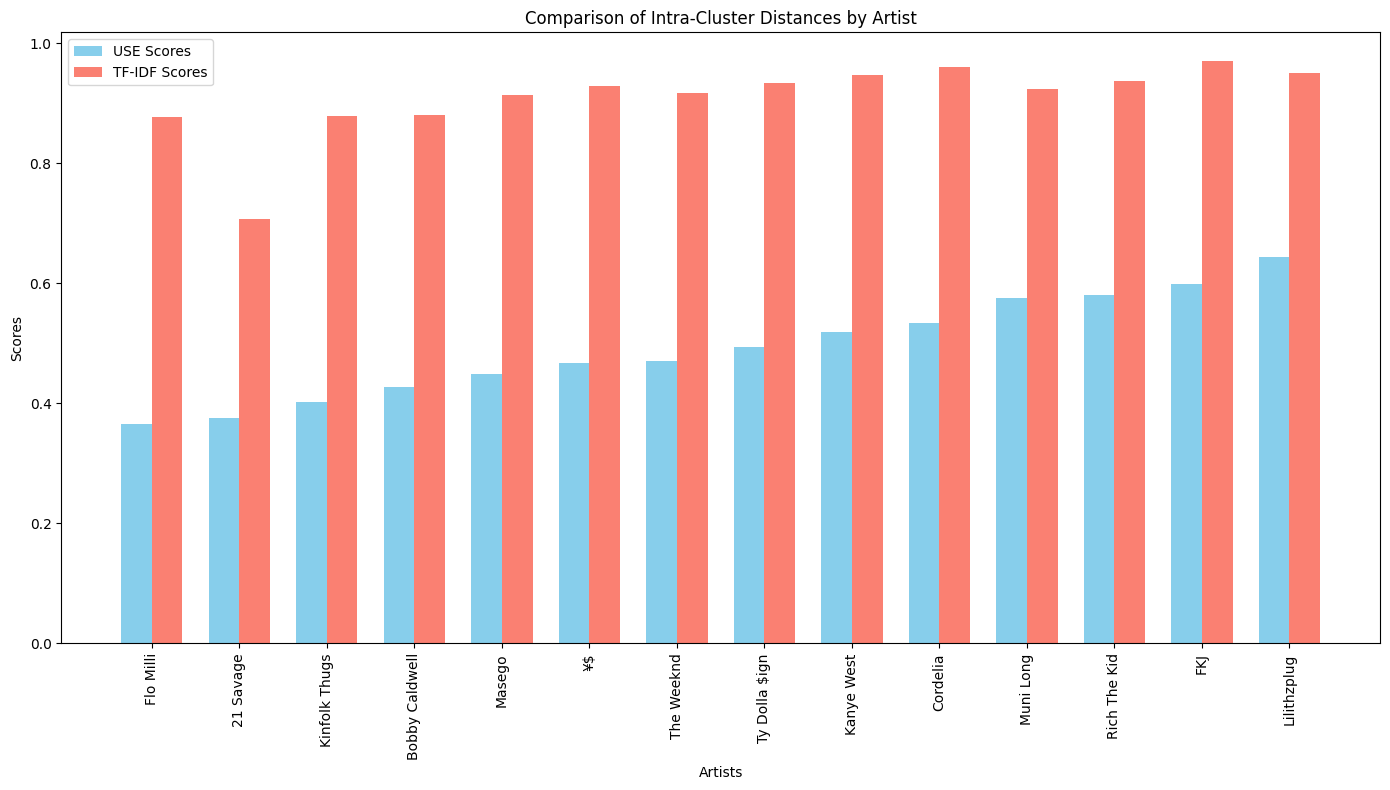

In [23]:
fig, ax = plt.subplots(figsize=(14, 8))
width = 0.35  # the width of the bars

indices = range(len(combined_scores_df))  


colors_use = 'skyblue'
colors_tfidf = 'salmon'

rects1 = ax.bar(indices, combined_scores_df['USE Scores'], width, label='USE Scores', color=colors_use)
rects2 = ax.bar([i + width for i in indices], combined_scores_df['TF-IDF Scores'], width, label='TF-IDF Scores', color=colors_tfidf)

ax.set_xlabel('Artists')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Intra-Cluster Distances by Artist')
ax.set_xticks([i + width / 2 for i in indices])
ax.set_xticklabels(combined_scores_df['artist'])
plt.xticks(rotation=90)
ax.legend()

fig.tight_layout()
plt.show()


/var/folders/94/hzlwrw5d571cgm5snsf618b00000gn/T/ipykernel_80124/821708665.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20b', len(combined_scores_df))


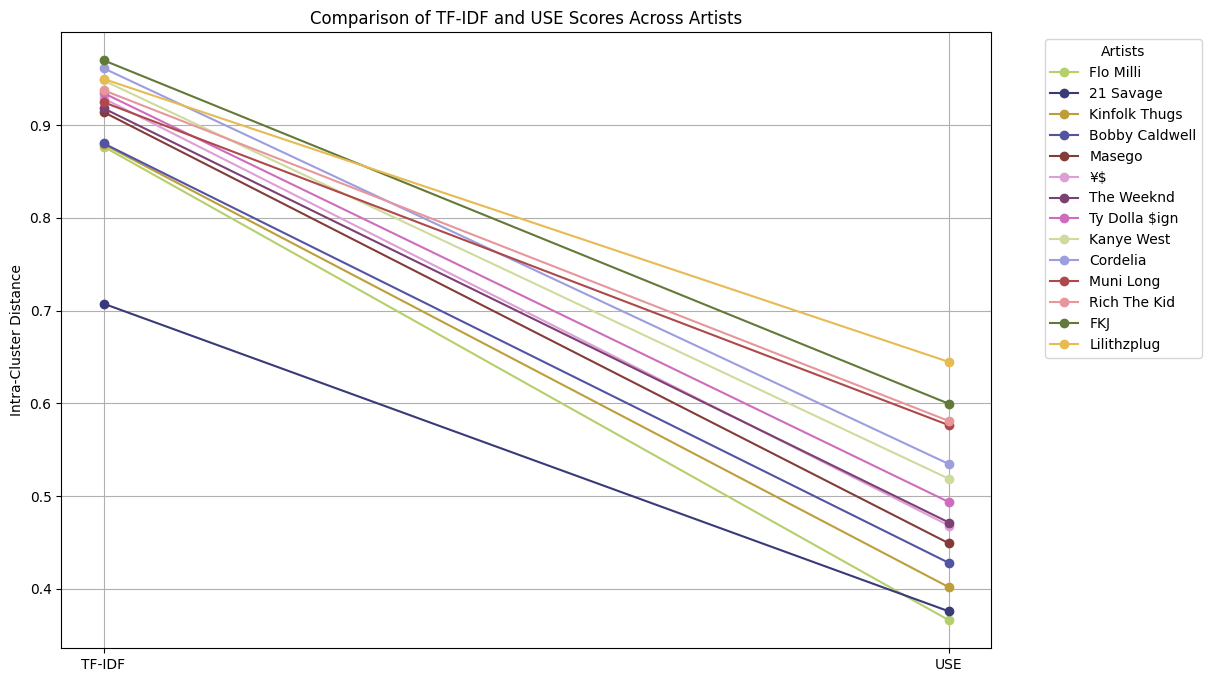

In [24]:
cmap = plt.cm.get_cmap('tab20b', len(combined_scores_df))  

plt.figure(figsize=(12, 8))

for i, row in combined_scores_df.iterrows():
    artist = row['artist']
    tfidf_score = row['TF-IDF Scores']
    use_score = row['USE Scores']
    
    # Generate a color from the colormap
    color = cmap(i)

    plt.plot(['TF-IDF', 'USE'], [tfidf_score, use_score], '-o', label=artist, color=color)

plt.title('Comparison of TF-IDF and USE Scores Across Artists')
plt.ylabel('Intra-Cluster Distance')
plt.legend(title='Artists', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

plt.show()

# Case Study 1: Flo Milli

We want to analyze the relationship between her viral song and other top songs through clustering/visualizations to reveal patterns that may contribute to a song's success/viral status on TikTok

- **USE Score**: 0.366  
   This score is among the lowest, indicating high semantic cohesion. This suggests that Flo Milli’s songs are closely related in terms of underlying meanings and themes, despite possibly using varied language.

- **TF-IDF Score**: 0.876  
   This score is also among the lowest!


In [25]:
#Reading in our data collection
our_data = pd.read_csv("songs_with_lyrics.csv")

# Filter the DataFrame to only include rows w/ Flo Milli
our_data[our_data['artist'] == 'Flo Milli']

,file_name,track_name,artist,lyrics
104,share_video_7323574076390362370_.mp3,Never Lose Me (Mixed),Flo Milli,[Intro: Flo Milli]\nNever had a bitch like me ...
198,share_video_7324031406592527649_.mp3,Never Lose Me (Mixed),Flo Milli,[Intro: Flo Milli]\nNever had a bitch like me ...
277,share_video_7321071284601785632_.mp3,Never Lose Me (Mixed),Flo Milli,[Intro: Flo Milli]\nNever had a bitch like me ...
306,share_video_7309685284025683246_.mp3,Never Lose Me (Mixed),Flo Milli,[Intro: Flo Milli]\nNever had a bitch like me ...


So, the song titled **"Never Lose Me"** is the viral song. 
Let's check to make see if it is already in our top_songs DF.

In [26]:
flo_milli_data = df[df['artist'] == 'Flo Milli']

flo_milli_data #Never Lose Me is in there! 

,artist,song_name,viral,lyrics,clean_lyrics,processed_lyrics,tfidf_vector,use_embeddings
22,Flo Milli,Edible (feat. Gunna),False,"(Ooh-la-la, Bangladesh)\n\n\nI ain't had no go...",Oohlala Bangladesh I aint had no good dick i...,oohlala bangladesh aint good dick month scare ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.023240788, -0.058278408, 0.05666656, 0.042..."
23,Flo Milli,In The Party,False,"(La, la, la, la, la, la) Flo Milli shit\n(La, ...",La la la la la la Flo Milli shit La la la la l...,la la la la la la flo milli shit la la la la l...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.021880183, -0.055662118, 0.05595904, 0.0489..."
24,Flo Milli,Beef FloMix,False,"Hah\nFlo Milli shit, bitch\n\n\nI like cash an...",Hah Flo Milli shit bitch I like cash and my ...,hah flo milli shit bitch like cash hair ass da...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.028039403, -0.062161114, 0.06338531, 0.0524..."
25,Flo Milli,Rodeo (Remix),False,Yeah\n\n\nI wanna fuck you right now\nReverse ...,Yeah I wanna fuck you right now Reverse that...,yeah wan na fuck right revers cowgirl im bucki...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.035159115, -0.05332786, 0.05344471, 0.04698..."
26,Flo Milli,Conceited,False,"(That's Fyre)\n\n\nFeelin' myself, I'm conceit...",Thats Fyre Feelin myself Im conceited Huh Fe...,that fyre feelin im conceit huh feelin im conc...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.026865406, -0.052575245, 0.05265974, 0.0507..."
27,Flo Milli,Never Lose Me,True,Never had a bitch like me in your life\nYou ai...,Never had a bitch like me in your life You ain...,never bitch like life aint never bitch like li...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.010638397, -0.058230676, 0.058450237, 0.057..."


In [27]:
from sklearn.metrics.pairwise import cosine_similarity

viral_index = flo_milli_data[flo_milli_data['song_name'] == 'Never Lose Me'].index[0]

# Extract the embedding for "Never Lose Me"
viral_embedding = flo_milli_data.loc[viral_index, 'use_embeddings']

# Calculate cosine similarity between "Never Lose Me" and all songs
similarities = cosine_similarity([viral_embedding], flo_milli_data['use_embeddings'].tolist())[0]

# Print the similarity scores with the corresponding song names for clarity
for i, similarity in enumerate(similarities):
    song_name = flo_milli_data.iloc[i]['song_name']
    print(f"Similarity between 'Never Lose Me' and '{song_name}': {similarity:.3f}")


Similarity between 'Never Lose Me' and 'Edible (feat. Gunna)': 0.632
Similarity between 'Never Lose Me' and 'In The Party': 0.666
Similarity between 'Never Lose Me' and 'Beef FloMix': 0.745
Similarity between 'Never Lose Me' and 'Rodeo (Remix)': 0.596
Similarity between 'Never Lose Me' and 'Conceited': 0.595
Similarity between 'Never Lose Me' and 'Never Lose Me': 1.000


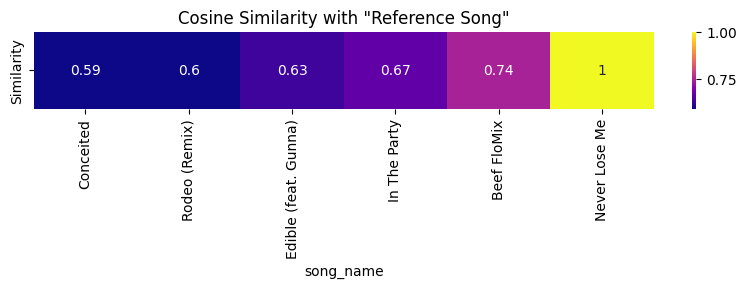

In [30]:
similarity_df = pd.DataFrame(similarities.reshape(1, -1), columns=flo_milli_data['song_name'], index=['Similarity'])

# Transpose to sort by similarity
similarity_df = similarity_df.T

# Sort the DataFrame by 'Similarity' values
similarity_df = similarity_df.sort_values(by='Similarity', ascending=True)

# Transpose it back to the original form
similarity_df = similarity_df.T

# Plotting the sorted heatmap
plt.figure(figsize=(10, 1))  # Adjust the figure size as necessary
sns.heatmap(similarity_df, annot=True, cmap="plasma", cbar=True)
plt.title('Cosine Similarity with "Reference Song"')
plt.show()

In [31]:
def gini_similarity_index(viral_song_topics, other_song_topics):
    
    # Calculate absolute differences and sum them
    abs_diff = np.abs(viral_song_topics - other_song_topics)
    total_difference = np.sum(abs_diff, axis=1)
    
    # Maximum possible sum of differences
    max_diff = np.sum(np.maximum(viral_song_topics, other_song_topics), axis=1)
    
    # Gini-Similarity Index
    gini_index = total_difference / max_diff
    
    # Average to get a single metric for the artist
    average_gini_index = np.mean(gini_index)
    
    return average_gini_index


In [32]:

average_gini = gini_similarity_index(viral_song_topics, other_song_topics)
print("Average Gini-Similarity Index:", average_gini)


NameError: name 'viral_song_topics' is not defined

### Case Study 2

In [33]:
our_data[our_data['artist'] == 'Lilithzplug'] #CLEARED is viral song

,file_name,track_name,artist,lyrics
169,share_video_7336420107171663137_.mp3,CLEARED - Remix,Lilithzplug,"[Intro]\n(\nI'll do it, you lazy bitch\n)\n[Ch..."
208,share_video_7339596534545173791_.mp3,CLEARED - Remix,Lilithzplug,"[Intro]\n(\nI'll do it, you lazy bitch\n)\n[Ch..."
261,share_video_7335581309290515744_.mp3,CLEARED - Remix,Lilithzplug,"[Intro]\n(\nI'll do it, you lazy bitch\n)\n[Ch..."
319,share_video_7328932932943383814_.mp3,CLEARED - Remix,Lilithzplug,"[Intro]\n(\nI'll do it, you lazy bitch\n)\n[Ch..."
333,share_video_7337553644369366314_.mp3,CLEARED - Remix,Lilithzplug,"[Intro]\n(\nI'll do it, you lazy bitch\n)\n[Ch..."
337,share_video_7336487071323786539_.mp3,CLEARED - Remix,Lilithzplug,"[Intro]\n(\nI'll do it, you lazy bitch\n)\n[Ch..."


In [34]:
Lil_data = df[df['artist'] == 'Lilithzplug']
Lil_data

,artist,song_name,viral,lyrics,clean_lyrics,processed_lyrics,tfidf_vector,use_embeddings
41,Lilithzplug,CLEARED - Remix,True,"(I'll do it, you lazy bitch)\n\n\nFuck it, let...",Ill do it you lazy bitch Fuck it lets go Tak...,ill lazi bitch fuck let go take real slow take...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.020085601, -0.059255, 0.062069185, 0.03800..."
42,Lilithzplug,WillyWonka,False,Take me to the factory\nWhere my heart will bl...,Take me to the factory Where my heart will ble...,take factori heart bleed sweet insid that favo...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.053891372, -0.055091567, 0.04309751, 0.055..."
43,Lilithzplug,Don't Fkn Cry,False,"I mean, I'm sure you can be a sweet kid when y...",I mean Im sure you can be a sweet kid when you...,mean im sure sweet kid want right your realli ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.041574027, -0.057130147, 0.057897877, 0.047..."
44,Lilithzplug,Aliyah,False,For all the people that was sick about the moo...,For all the people that was sick about the moo...,peopl sick moon boot beach prepar sick 2023 ca...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.042...","[0.017367877, -0.06300501, 0.067987725, 0.0201..."
45,Lilithzplug,YoU,False,—treat women is by treating them like whores\n...,treat women is by treating them like whores We...,treat women treat like whore well your whore t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.03834333, -0.06309868, 0.06302911, -0.0222..."
46,Lilithzplug,Do you even see me?,False,Haven't we been through this before\nIf you se...,Havent we been through this before If you see ...,havent see chang number lock door see tri eras...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.022695761, -0.053502336, 0.05371937, -0.031..."
47,Lilithzplug,Imaginary Lover,False,I remember the simple times back in November\n...,I remember the simple times back in November W...,rememb simpl time back novemb protect thing co...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.036673002, 0.03648833, 0.04503847, 0.027485..."
48,Lilithzplug,Prom Queen,False,How could it be me?\nHow could it be me?\nHow ...,How could it be me How could it be me How coul...,could could could could high school prom queen...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.040524915, -0.048098367, 0.050352175, -0.0..."


In [48]:
index_viral = Lil_data[Lil_data['song_name'] == 'CLEARED - Remix'].index[0]

viral_embedding = Lil_data.loc[index_viral, 'use_embeddings']

similarities2 = cosine_similarity([viral_embedding], Lil_data['use_embeddings'].tolist())[0]

# Print the similarity scores with the corresponding song names for clarity
for i, similarity in enumerate(similarities):
    song_name = Lil_data.iloc[i]['song_name']
    print(f"Similarity between 'CLEARED - Remix' and '{song_name}': {similarity:.3f}")



Similarity between 'CLEARED - Remix' and 'CLEARED - Remix': 0.632
Similarity between 'CLEARED - Remix' and 'WillyWonka': 0.666
Similarity between 'CLEARED - Remix' and 'Don't Fkn Cry': 0.745
Similarity between 'CLEARED - Remix' and 'Aliyah': 0.596
Similarity between 'CLEARED - Remix' and 'YoU': 0.595
Similarity between 'CLEARED - Remix' and 'Do you even see me?': 1.000


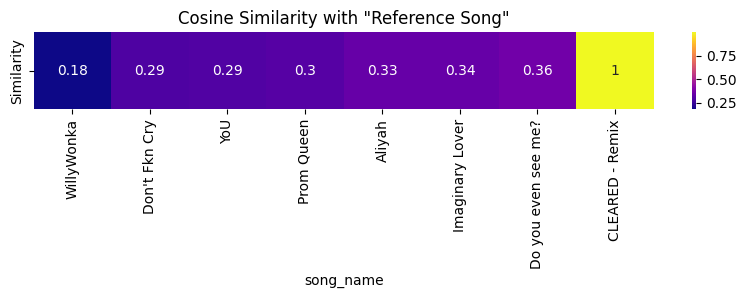

In [49]:
similarity_df = pd.DataFrame(similarities2.reshape(1, -1), columns=Lil_data['song_name'], index=['Similarity'])

similarity_df = similarity_df.T

similarity_df = similarity_df.sort_values(by='Similarity', ascending=True)

# Transpose it back to the original form
similarity_df = similarity_df.T

# Plotting the sorted heatmap
plt.figure(figsize=(10, 1))  # Adjust the figure size as necessary
sns.heatmap(similarity_df, annot=True, cmap="plasma", cbar=True)
plt.title('Cosine Similarity with "Reference Song"')
plt.show()